# Task 14. JIT the Mandelbrot Fractal

Separate exercise notebook or use your own Mandelbrot code 

1. Profile the code, find the bottlenecks
2. Use Numba to speed up the code
3. Compare the timing

In [1]:
!pip install snakeviz

In [2]:
!pip install line_profiler

In [3]:
import numpy as np
import numba as nb

import matplotlib.pyplot as plt
from numba import jit, njit

import snakeviz
import line_profiler
import cProfile

In [4]:
golden = (1 + 5 ** 0.5) / 2

In [102]:
def julia_map(z, c):
    return z ** 2 + c


def check_for_convergence(z, c, n_iterations, max_module):
    converges = True
    
    for i in range(1, n_iterations + 1):
        z = julia_map(z, c)
        
        if abs(z) > max_module:
            converges = False
            break
    
    ratio = i / n_iterations
    return ratio, converges


def initialize_julia_set(x_range, y_range):
    return np.zeros((x_range, y_range))


def construct_julia_set(x_range, y_range, x_min, y_min, x_max, y_max, c, max_module, n_iterations):
    width, height = x_max - x_min, y_max - y_min
    julia_set = initialize_julia_set(x_range, y_range)

    for i in range(x_range):
        for j in range(y_range):

            z = complex(i / x_range * width + x_min, j / y_range * height + y_min)
            ratio, converges = check_for_convergence(z, c, n_iterations, max_module)
            julia_set[i, j] = 1 - np.sqrt(ratio)
    
    return julia_set

In [103]:
x_range, y_range = 500, 500

x_min, x_max = -1.5, 1.5
width = x_max - x_min

y_min, y_max = -1.5, 1.5
height = y_max - y_min

In [104]:
c = 1 - golden
max_module = 4
n_iterations = 200

In [105]:
args = (x_range, y_range, x_min, y_min, x_max, y_max, c, max_module, n_iterations)

In [106]:
%%time
_ = construct_julia_set(*args)

CPU times: user 5.43 s, sys: 26 ms, total: 5.46 s
Wall time: 5.47 s


In [107]:
factor = 1e2
rr = np.logspace(0, 4, 5, base=2).astype(int) * int(factor)
results_original_code = []

for r in rr:
    x_range = y_range = r

    sup_args = (x_range, y_range, x_min, y_min, x_max, y_max, c, max_module, n_iterations)
    results = %timeit -n 1 -o construct_julia_set(*sup_args)

    results_original_code.append(results.best)

results_original_code = np.array(results_original_code)

1 loop, best of 5: 221 ms per loop
1 loop, best of 5: 894 ms per loop
1 loop, best of 5: 3.6 s per loop
1 loop, best of 5: 14.4 s per loop
1 loop, best of 5: 58 s per loop


## Profile `construct_julia_set` Function using `cProfile`

In [108]:
cProfile.run('construct_julia_set(*args)')

         28799688 function calls in 9.187 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 14274841    2.515    0.000    2.515    0.000 <ipython-input-102-3083748f9d24>:1(julia_map)
        1    0.000    0.000    0.002    0.002 <ipython-input-102-3083748f9d24>:19(initialize_julia_set)
        1    0.591    0.591    9.186    9.186 <ipython-input-102-3083748f9d24>:23(construct_julia_set)
   250000    4.842    0.000    8.593    0.000 <ipython-input-102-3083748f9d24>:5(check_for_convergence)
        1    0.000    0.000    9.187    9.187 <string>:1(<module>)
 14274841    1.236    0.000    1.236    0.000 {built-in method builtins.abs}
        1    0.000    0.000    9.187    9.187 {built-in method builtins.exec}
        1    0.002    0.002    0.002    0.002 {built-in method numpy.zeros}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




## And using `line_profiler`

In [109]:
%load_ext line_profiler
%lprun -T line_profiler_output.txt -f construct_julia_set construct_julia_set(*args)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler

*** Profile printout saved to text file 'line_profiler_output.txt'. 


In [110]:
!cat line_profiler_output.txt

Timer unit: 1e-06 s

Total time: 14.9982 s
File: <ipython-input-102-3083748f9d24>
Function: construct_julia_set at line 23

Line #      Hits         Time  Per Hit   % Time  Line Contents
    23                                           def construct_julia_set(x_range, y_range, x_min, y_min, x_max, y_max, c, max_module, n_iterations):
    24         1          3.0      3.0      0.0      width, height = x_max - x_min, y_max - y_min
    25         1        577.0    577.0      0.0      julia_set = initialize_julia_set(x_range, y_range)
    26                                           
    27       501        329.0      0.7      0.0      for i in range(x_range):
    28    250500     163256.0      0.7      1.1          for j in range(y_range):
    29                                           
    30    250000     253783.0      1.0      1.7              z = complex(i / x_range * width + x_min, j / y_range * height + y_min)
    31    250000   13982748.0     55.9     93.2              ratio, co

## Try to Exploit `numba`

In [111]:
# ---------------------------------- numba knows about numbers and logical variables ----------------------------------
@njit
def julia_map(z, c):
    return z ** 2 + c


@njit
def check_for_convergence(z, c, n_iterations, max_module):
    converges = True
    
    for i in range(1, n_iterations + 1):
        z = julia_map(z, c)
        
        if abs(z) > max_module:
            converges = False
            break
    
    ratio = i / n_iterations
    return ratio, converges


# --------------------------------------- and numba understands numpy functions ---------------------------------------
@njit
def initialize_julia_set(x_range, y_range):
    return np.zeros((x_range, y_range))

@njit
def construct_julia_set(x_range, y_range, x_min, y_min, x_max, y_max, c, max_module, n_iterations):
    width, height = x_max - x_min, y_max - y_min
    julia_set = initialize_julia_set(x_range, y_range)

    for i in range(x_range):
        for j in range(y_range):

            z = complex(i / x_range * width + x_min, j / y_range * height + y_min)
            ratio, converges = check_for_convergence(z, c, n_iterations, max_module)
            julia_set[i, j] = 1 - np.sqrt(ratio)
    
    return julia_set

In [112]:
%%time
_ = construct_julia_set(*args)

CPU times: user 667 ms, sys: 9.01 ms, total: 676 ms
Wall time: 674 ms


We should recall that `numba` has to compile given function before it executes the machine code version of this function, which takes time. However, once the compilation has taken place `numba` caches the machine code version of given function for the particular types of arguments presented. If it is called again the with same types, it can reuse the cached version instead of having to compile again — this is the reason why we have to skip the evuluation in the previous cell.

In [113]:
factor = 1e2
rr = np.logspace(0, 4, 5, base=2).astype(int) * int(factor)
results_compiled_code = []

for r in rr:
    x_range = y_range = r

    sup_args = (x_range, y_range, x_min, y_min, x_max, y_max, c, max_module, n_iterations)
    results = %timeit -n 1 -o construct_julia_set(*sup_args)

    results_compiled_code.append(results.best)

results_compiled_code = np.array(results_compiled_code)

1 loop, best of 5: 7.41 ms per loop
1 loop, best of 5: 30 ms per loop
1 loop, best of 5: 122 ms per loop
1 loop, best of 5: 474 ms per loop
1 loop, best of 5: 1.91 s per loop


## Compare Performance of the Original Code and the Compiled One Using `numba`

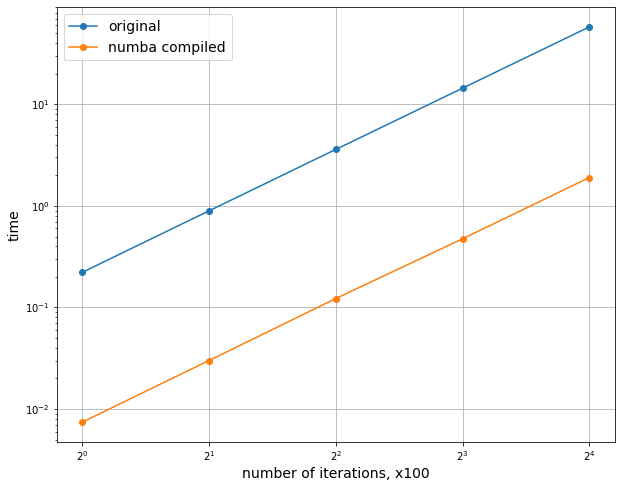

In [114]:
plt.figure(figsize=(10, 8))

plt.plot(rr / factor, results_original_code, '-o', label='original')
plt.plot(rr / factor, results_compiled_code, '-o', label='numba compiled')

plt.xlabel(f'number of iterations, x{int(factor)}', fontsize=14)
plt.ylabel('time', fontsize=14)

plt.yscale('log', basey=10)
plt.xscale('log', basex=2)

plt.legend(fontsize=14)
plt.grid()
plt.show()

In [115]:
results_original_code / results_compiled_code

array([29.84252355, 29.80623134, 29.4077087 , 30.43462213, 30.4294402 ])

As can be seen, the `numba` compiled code is **30 times** faster!

# Task 15. N-Body Problem

Many physical problems require the evaluation of all pairwise interactions of a large number of particles, so-called N-body problems. These problems arise in molecular dynamics, astrodynamics and electromagnetics among others. 

Their pairwise interactions can be expressed as:

\begin{equation}
f_i = \sum_{j=1}^n{P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)w_j} \ \ \ \text{for } i=1,2,...,n 
\end{equation}

*  where subscripts $i$,  $j$ respectively denote *target* and *source*
*  $f_i$ can be a *potential* (or *force*) at target point $i$
*  $w_j$ is the *source weight* 
*  $\boldsymbol{x}_i, \boldsymbol{x}_j$ are the *spatial positions* of particles 
*  $P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)$ is the *interaction kernel*. 

In order to evalute the potential $f_i$ at a target point $i$, we have to loop over each source particle $j$. Since there are $n$ target points $i$, this 'brute-force' approach costs $\mathcal{O} \left(n^2 \right)$ operations. 

One possible approach in this kind of problem is to define a few classes, say `Point` and `Particle` and then loop over the objects and perform the necessary point-to-point calculations.

In [74]:
class Point():
    """    
    Arguments:
        domain: the domain of random generated coordinates x,y,z, 
                default=1.0
    
    Attributes:
        x, y, z: coordinates of the point
    """
    def __init__(self, domain=1.0):
        self.x = domain * np.random.random()
        self.y = domain * np.random.random()
        self.z = domain * np.random.random()
            
    def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5

In [75]:
class Particle(Point):
    """    
    Attributes:
        m: mass of the particle
        phi: the potential of the particle
    """
    
    def __init__(self, domain=1.0, m=1.0):
        Point.__init__(self, domain)
        self.m = m
        self.phi = 0.

Now we create a list of `n` random particles, define a function to calculate their interaction via direct summation and run!

In [76]:
def create_n_random_particles(n, m, domain=1.0):
    return [Particle(domain, m) for _ in range(n)]

In [77]:
n = 1000
m = 1 / n
particles = create_n_random_particles(n, m)

In [78]:
def direct_sum(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """

    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i + 1:]):
            r = target.distance(source)
            target.phi += source.m / r

In [79]:
%%time
direct_sum(particles)

CPU times: user 961 ms, sys: 5 ms, total: 966 ms
Wall time: 970 ms


In [51]:
nn = np.logspace(8, 12, 5, base=2).astype(int)
results_original_code = []

for n in nn:
    m = 1 / n # for instance
    sup_particles = create_n_random_particles(n, m)
    results = %timeit -n 1 -o direct_sum(sup_particles)

    results_original_code.append(results.best)

results_original_code = np.array(results_original_code)

1 loop, best of 5: 77.9 ms per loop
1 loop, best of 5: 308 ms per loop
1 loop, best of 5: 1.26 s per loop
1 loop, best of 5: 5.04 s per loop
1 loop, best of 5: 20.7 s per loop


## Profile `direct_sum` Function using `line_profiler`

In [80]:
%load_ext line_profiler
%lprun -T line_profiler_output.txt -f direct_sum direct_sum(particles)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler

*** Profile printout saved to text file 'line_profiler_output.txt'. 


In [81]:
!cat line_profiler_output.txt

Timer unit: 1e-06 s

Total time: 2.76532 s
File: <ipython-input-78-8ffb2e79a39a>
Function: direct_sum at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def direct_sum(particles):
     2                                               """
     3                                               Calculate the potential at each particle
     4                                               using direct summation method.
     5                                           
     6                                               Arguments:
     7                                                   particles: the list of particles
     8                                           
     9                                               """
    10                                           
    11      1001       1006.0      1.0      0.0      for i, target in enumerate(particles):
    12   1000000     427782.0      0.4     15.5          for

## How Do We Use `numba` on This Problem?
Problem: Numba doesn't support jitting native Python classes.  There is a `jit_class` structure in Numba but it's still in early development.

But it's nice to have attributes for literate programming.

Solution: NumPy custom dtypes.

In [82]:
particle_dtype = np.dtype({'names': ['x','y','z','m','phi'], 
                           'formats': [np.double, np.double, np.double, np.double, np.double]})

In [83]:
my_array = np.zeros(3, dtype=particle_dtype)

In [84]:
my_array

array([(0., 0., 0., 0., 0.), (0., 0., 0., 0., 0.), (0., 0., 0., 0., 0.)],
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('phi', '<f8')])

In [85]:
my_array[0]['x'] = 2.0

In [86]:
my_array

array([(2., 0., 0., 0., 0.), (0., 0., 0., 0., 0.), (0., 0., 0., 0., 0.)],
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('phi', '<f8')])

## Exercise 1

Write a function `create_n_random_particles` that takes the arguments `n` (number of particles), `m` (mass of every particle) and a domain within to generate a random number (as in the class above).
It should create an array with `n` elements and `dtype=particle_dtype` and then return that array.

For each particle, the mass should be initialized to the value of `m` and the potential `phi` initialized to zero.

For the `x` component of a given particle `p`, you might do something like

```python
p['x'] = domain * numpy.random.random()
```

In [87]:
particles = np.zeros((n), dtype=particle_dtype)

In [88]:
@njit
def create_n_random_particles(n, m, domain=1.0):
    '''
    Creates `n` particles with mass `m` with random coordinates
    between 0 and `domain`
    '''
    particles = np.zeros((n), dtype=particle_dtype)

    for particle in particles:
        particle['x'] = domain * np.random.random()
        particle['y'] = domain * np.random.random()
        particle['z'] = domain * np.random.random()

        particle['m'] = m

    return particles

In [89]:
particles = create_n_random_particles(1000, .001, 1)

## Exercise 2

Write a JITted function `distance` to calculate the distance between two particles of dtype `particle_dtype`

Here's the `distance` method from the `Particle` class as a reference:

```python
def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5
```

In [90]:
@njit
def distance(particle_1, particle_2):
    '''calculate the distance between two particles'''
    
    return ((particle_1['x'] - particle_2['x'])**2 + 
            (particle_1['y'] - particle_2['y'])**2 + 
            (particle_1['z'] - particle_2['z'])**2)**.5

In [91]:
distance(particles[0], particles[1])

0.3571408867855002

## Exercise 3
Modify the original `direct_sum` function (copied below for reference) to instead work a NumPy array of particles.  Loop over each element in the array and calculate its total potential.

```python
def direct_sum(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i + 1:]):
            r = target.distance(source)
            target.phi += source.m / r
```

In [92]:
@njit
def direct_sum(particles):
    for i, target in enumerate(particles):
        for j, source in enumerate(particles):
            if j != i:
                r = distance(target, source)
                target['phi'] += source['m'] / r

In [93]:
%%time
direct_sum(particles) # this code also serves for compilation

CPU times: user 154 ms, sys: 3 ms, total: 157 ms
Wall time: 158 ms


In [94]:
nn = np.logspace(8, 12, 5, base=2).astype(int)
results_compiled_code = []

for n in nn:
    m = 1 / n # for instance
    particles = create_n_random_particles(n, m)
    results = %timeit -n 1 -o direct_sum(particles)

    results_compiled_code.append(results.best)

results_compiled_code = np.array(results_compiled_code)

1 loop, best of 5: 262 µs per loop
1 loop, best of 5: 1.05 ms per loop
1 loop, best of 5: 4.24 ms per loop
1 loop, best of 5: 16.8 ms per loop
1 loop, best of 5: 68 ms per loop


## Compare Performance of the Original Code and the Compiled One Using `numba`

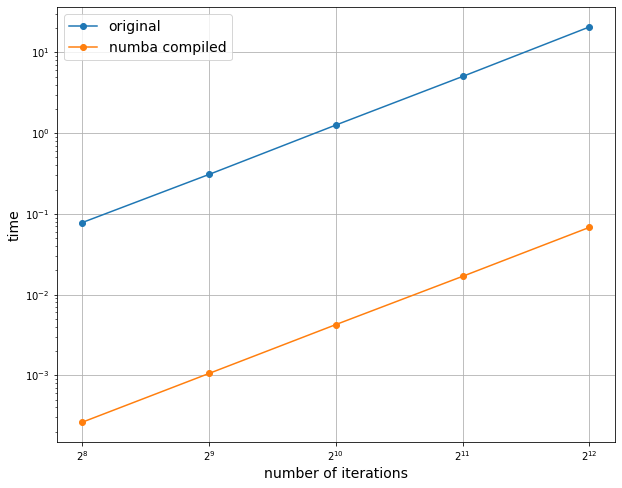

In [95]:
plt.figure(figsize=(10, 8))

plt.plot(nn, results_original_code, '-o', label='original')
plt.plot(nn, results_compiled_code, '-o', label='numba compiled')

plt.xlabel('number of iterations', fontsize=14)
plt.ylabel('time', fontsize=14)

plt.yscale('log', basey=10)
plt.xscale('log', basex=2)

plt.legend(fontsize=14)
plt.grid()
plt.show()

In [96]:
results_original_code / results_compiled_code

array([297.63112478, 292.317324  , 296.43835118, 299.44667595,
       304.6830549 ])

This particular problem has even more space for speedup — the `numba` compiled code is **300 times faster**!